# Spread Spectrum Watermarking

Previously we have seen LSB embedding and detection technique.

LSB is extremely trivial, so this time we will use Spread Spectrum watermarking.

Spread Spectrum watermarking: an independent and identically distributed (i.i.d) Gaussian random vector (the watermark) is **imperceptibly** inserted in a **spread-spectrum-like fashion** into the perceptually most significant spectral components of the data.

In [1]:
import os
from math import sqrt

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import dct, idct
from scipy.signal import convolve2d

# get required images
if not os.path.isfile('lena.bmp'):
    !wget -O lena.bmp "https://drive.google.com/uc?export=download&id=17MVOgbOEOqeOwZCzXsIJMDzW5Dw9-8zm"
if not os.path.isfile('csf.csv'):
    !wget -O csf.csv "https://drive.google.com/uc?export=download&id=1w43k1BTfrWm6X0rqAOQhrbX6JDhIKTRW"

# define settings
img_path = 'lena.bmp'
mark_size = 1024
alpha = 24  #0.1
v = 'additive'  #'multiplictive'
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

## Embedding

In [2]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + (alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct, axis=1, norm='ortho'), axis=0, norm='ortho'))

    return mark, watermarked


mark, watermarked = embedding(image, mark_size, alpha, v)
cv2.imwrite('watermarked.bmp', watermarked)

True

## Quality

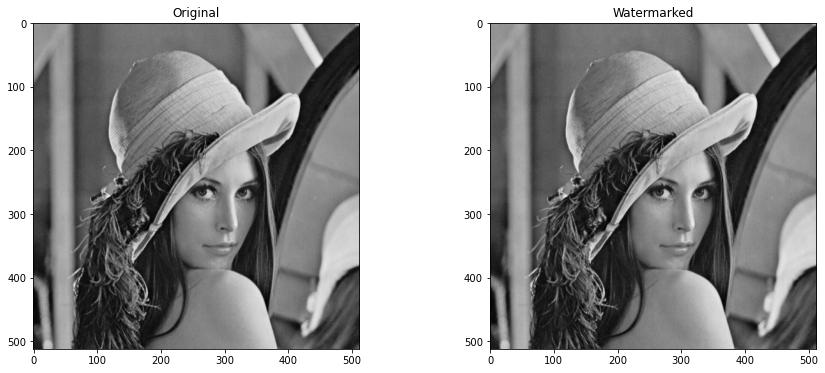

PSNR: 46.56dB
wPSNR: 52.43dB


In [3]:
def wpsnr(img1, img2):
    img1 = np.float32(img1) / 255.0
    img2 = np.float32(img2) / 255.0

    difference = img1 - img2
    same = not np.any(difference)
    if same is True:
        return 9999999
    csf = np.genfromtxt('csf.csv', delimiter=',')
    ew = convolve2d(difference, np.rot90(csf, 2), mode='valid')
    decibels = 20.0 * np.log10(1.0 / sqrt(np.mean(np.mean(ew ** 2))))
    return decibels


# Plot the two images side by side
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked, cmap='gray')
plt.show()

# Compute quality
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)

## EXERCISES:

1. Change the value of alpha
2. Change the size of the watermark
3. Compute the PSNR and WPSNR of watermarked images for 3 different values of alpha in the multiplicative version of the SS
4. Can you still detect the watermark if the image is attacked? Use different image processing techniques to see how the affect detection.
5. Play with the complete SS code (embedding + detection) and see what happens if you select different coefficients (e.g. low to mid frequencies) or if you embed the watermark only on some areas of the original image (thus, selecting areas in the spatial domain and exploiting block DCT instead of full frame DCT to perform the embedding).
6. We have seen how to embed and extract a watermark into the perceptually most significant spectral components of the data. This should allow to achieve robustness and imperceptibility. Can we do better? How?




## Detection

In [7]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size + 1]):
        if v == 'additive':
            w_ex[idx] = (wat_dct[loc] - ori_dct[loc]) / alpha
        elif v == 'multiplicative':
            w_ex[idx] = (wat_dct[loc] - ori_dct[loc]) / (alpha * ori_dct[loc])

    return w_ex


w_ex = detection(image, watermarked, alpha, mark_size, v)

## Deciding whether the mark is present or not using a threshold

In [11]:
def similarity(X, X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s


def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    SIM[0] = abs(sim)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = abs(similarity(w, r))

    SIM.sort()
    t = SIM[-2]
    T = t + (0.1 * t)
    print(T)
    return T


print(mark)
print(w_ex)

sim = similarity(mark, mark)
T = compute_thr(sim, mark_size, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

[1 0 0 ... 1 1 0]
[ 9.87246709e-01 -1.39291934e-02 -6.54206794e-02 ...  9.79516992e-01
  1.01231637e+00  5.78092771e-04]
15.872637557380656
Mark has been found. SIM = 22.383029
